For this program, I am going to use CNN.

In [1]:
import lime
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import lime.lime_tabular
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
## Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Assuming each feature is like a 1D 'image' channel, input_channels=1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # An example of an additional max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Fully connected layer, 64 * number_of_maxpooled_features -> 2 output features
        self.fc = nn.Linear(64 * 3, 2)  # Adjust the linear layer input size accordingly

    def forward(self, x):
        # Add a dimension to input for the channel (batch_size, channels, length)
        x = x.unsqueeze(1)  
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten the tensor so it can be fed into the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define a function that takes an array of instances and returns predictions
def predict_proba(X):
    # Convert the input to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float)
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = torch.softmax(outputs, dim=1)
    return probabilities.numpy()

In [3]:
## Load the data
InputData = pd.read_csv('Data/Dataset_spine_clean.csv')

## Seperate the features and labels
X = InputData.iloc[:, 1:13].values
y = InputData.iloc[:, 14].values

# Normalize your input data if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)  # Reshape if you flattened X for scaling

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert the datasets into PyTorch tensors and then into DataLoader for batching
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [4]:
# Adjust these parameters according to your dataset
input_size = X_train.shape[1]
hidden_sizes = [128, 64]  # Example: two hidden layers with 128 and 64 units
output_size = 2

# Initialize the CNN model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define the list to contain the loss for visualizing step
loss_values = []

epochs = 1000
for epoch in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.6322
Epoch [2/1000], Loss: 0.6110
Epoch [3/1000], Loss: 0.5676
Epoch [4/1000], Loss: 0.5675
Epoch [5/1000], Loss: 0.4675
Epoch [6/1000], Loss: 0.5392
Epoch [7/1000], Loss: 0.4980
Epoch [8/1000], Loss: 0.4375
Epoch [9/1000], Loss: 0.4339
Epoch [10/1000], Loss: 0.4678
Epoch [11/1000], Loss: 0.5223
Epoch [12/1000], Loss: 0.4298
Epoch [13/1000], Loss: 0.4362
Epoch [14/1000], Loss: 0.4636
Epoch [15/1000], Loss: 0.4110
Epoch [16/1000], Loss: 0.4292
Epoch [17/1000], Loss: 0.4075
Epoch [18/1000], Loss: 0.3555
Epoch [19/1000], Loss: 0.3372
Epoch [20/1000], Loss: 0.2952
Epoch [21/1000], Loss: 0.3466
Epoch [22/1000], Loss: 0.3783
Epoch [23/1000], Loss: 0.3769
Epoch [24/1000], Loss: 0.3190
Epoch [25/1000], Loss: 0.3065
Epoch [26/1000], Loss: 0.3000
Epoch [27/1000], Loss: 0.3089
Epoch [28/1000], Loss: 0.2754
Epoch [29/1000], Loss: 0.3048
Epoch [30/1000], Loss: 0.3755
Epoch [31/1000], Loss: 0.2762
Epoch [32/1000], Loss: 0.3230
Epoch [33/1000], Loss: 0.2717
Epoch [34/1000], Lo

In [5]:
model.eval()
# Containers for true labels and predictions
true_labels = []
predictions = []
probs = []

# No need to track gradients during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
        
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)
probs = np.array(probs)

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions, average='macro')
test_recall = recall_score(true_labels, predictions, average='macro')
test_f1 = f1_score(true_labels, predictions, average='macro')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.7419
Test Precision: 0.6815
Test Recall: 0.6540
Test F1 Score: 0.6630


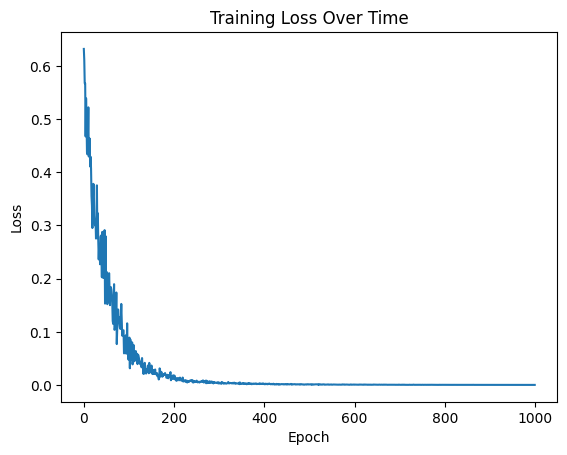

In [6]:
## Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

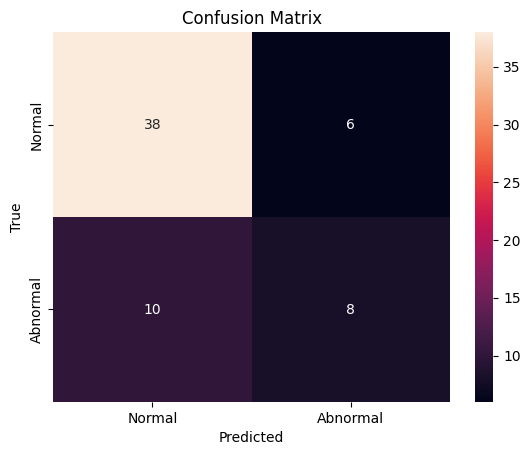

In [7]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

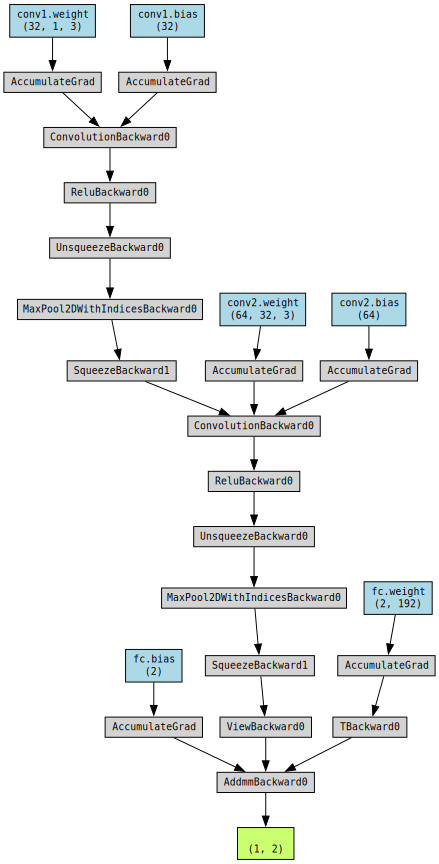

In [8]:
# Create a dummy input tensor matching the input size
dummy_input = torch.randn(1, 12)  # Batch size of 1, 12 features as an example
# Forward pass through the model
out = model(dummy_input)
# Generate the visual graph
dot = make_dot(out, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
# Display the graph (in Jupyter Notebook, for instance)
dot

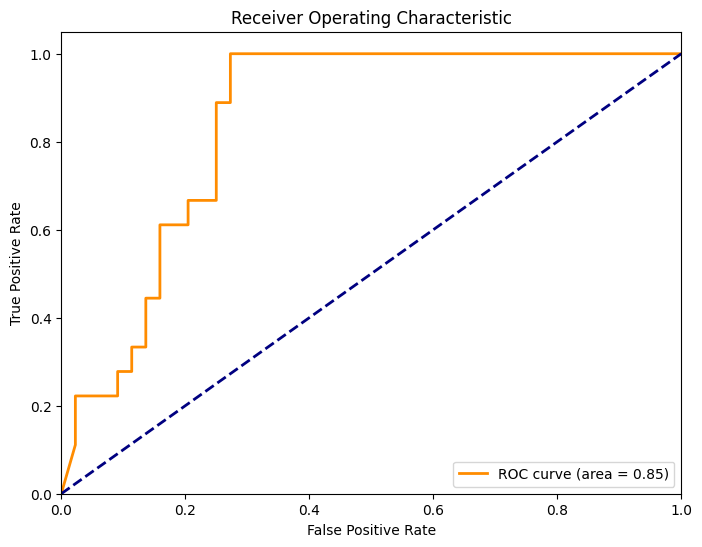

In [9]:
# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [10]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train,  # use the training data
    feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                     "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                     "sacrum_angle", "scoliosis_slope"],
    class_names=["Normal", "Abnormal"],
    mode='classification'
)

# Select an instance to explain
i = np.random.randint(0, X_test.shape[0])  # Randomly select an instance
instance = X_test[i]
exp = explainer.explain_instance(instance, predict_proba, num_features=12)

# Display the explanation in the notebook
exp.show_in_notebook(show_table=True, show_all=False)

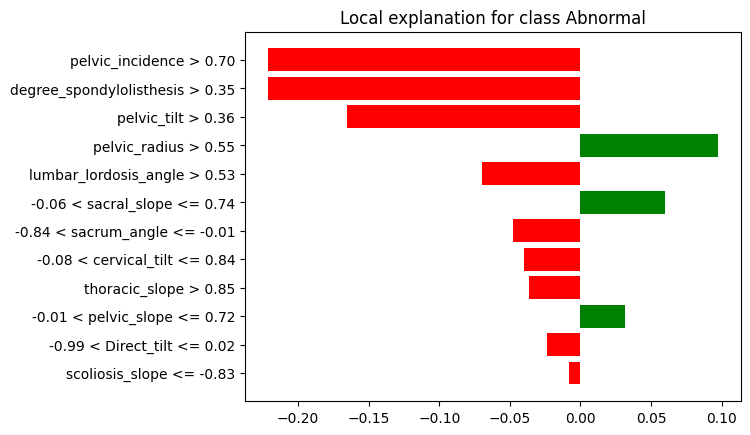

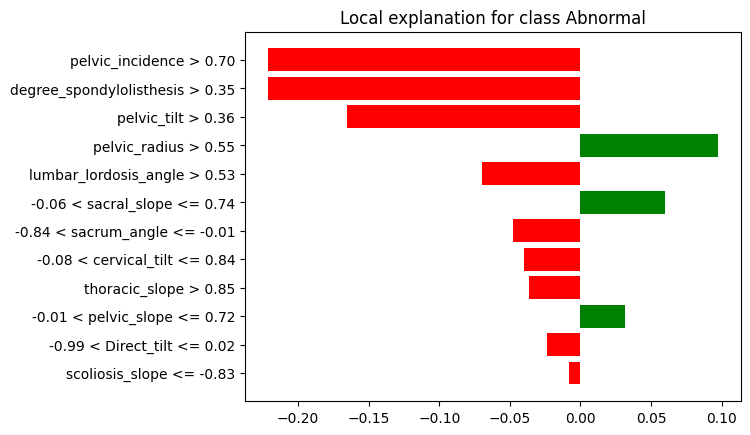

In [11]:
exp.as_pyplot_figure()

In [12]:
import shap
# Wrap the model's predict function to be compatible with SHAP
class WrappedModel:
    def __init__(self, model):
        self.model = model
    
    def predict(self, data):
        self.model.eval()
        tensor_data = torch.tensor(data, dtype=torch.float32)
        with torch.no_grad():
            output = self.model(tensor_data)
        return output.numpy()

# Instantiate the wrapped model
wrapped_model = WrappedModel(model)

## Seperate the features and labels
X = InputData.iloc[:, 1:13].values
y = InputData.iloc[:, 14].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare SHAP data
model.eval()
node_features_tensor = torch.tensor(X_test, dtype=torch.float32)
explainer = shap.KernelExplainer(wrapped_model.predict,
                                 node_features_tensor.numpy().astype(np.float64),
                                 feature_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                                                "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                                                "sacrum_angle", "scoliosis_slope"])

# Select a subset of data for SHAP explanation
sample_data = node_features_tensor.numpy().astype(np.float64)  # Example: using first 100 samples
shap_values = explainer.shap_values(sample_data)

  0%|          | 0/62 [00:00<?, ?it/s]

In [13]:
# Plot SHAP values for the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0], sample_data[0])

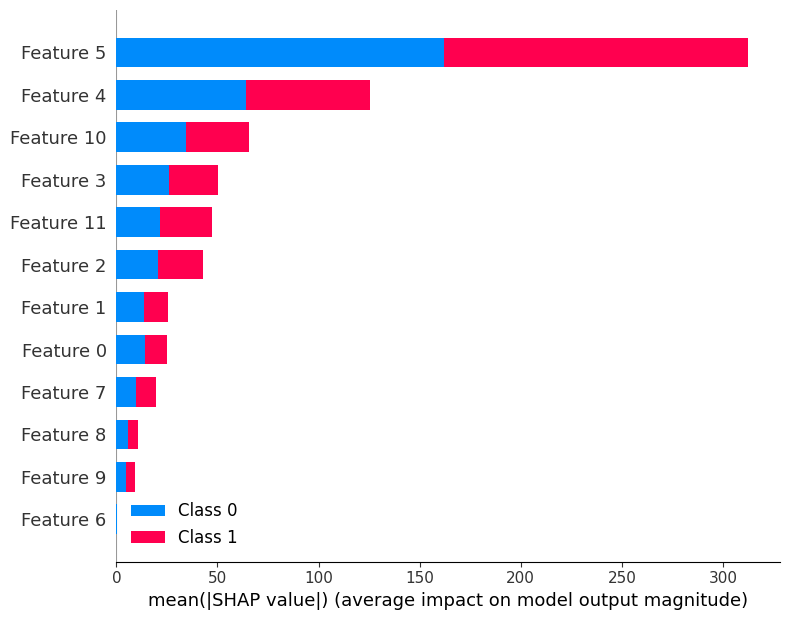

In [14]:
shap.summary_plot(shap_values, sample_data)

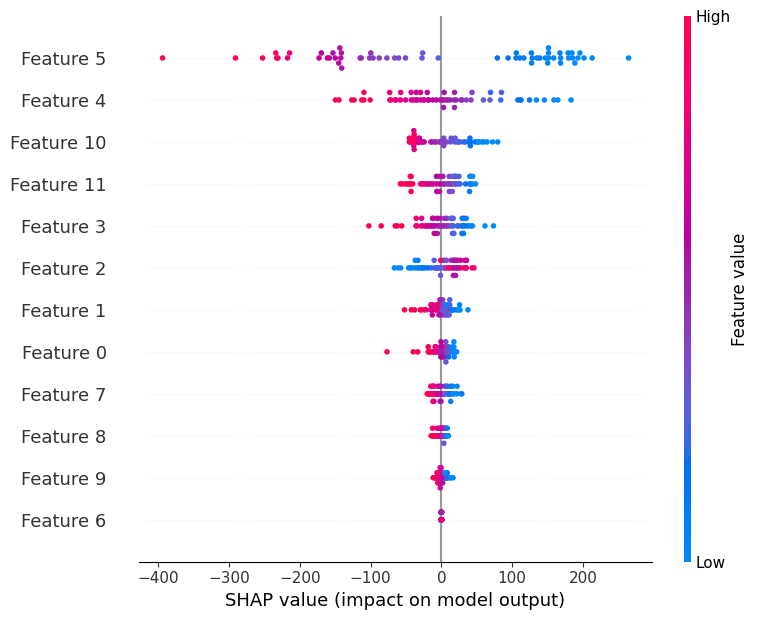

In [15]:
shap.summary_plot(shap_values[1], sample_data)